In [1]:
import glob 
import numpy as np 
import os 
import shutil 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model 
import keras 
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential 
from keras import optimizers  

In [2]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))        

In [3]:
IM_SHAPE=(225,225)
input_shape=(IM_SHAPE[0],IM_SHAPE[1],3)

In [4]:
batch_size = 32
num_classes = 2 
epochs = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input,
                                      validation_split=0.3)
val_datagen=ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input,
                                      validation_split=0.2)

# train_generator = train_datagen.flow_from_directory(
#     '../input/covidog/dataset',
#     target_size=IM_SHAPE,

#     batch_size=batch_size,
#     class_mode='categorical') # set as training data

train_generator_NEW = train_datagen.flow_from_directory(
    '../input/covidnew/ALL', # same directory as training data
    target_size=IM_SHAPE,
    subset='training',
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
validation_generator_NEW= train_datagen.flow_from_directory(
    '../input/covidnew/ALL',
#     batch_size=16,
    subset='validation',
    class_mode='categorical',
    target_size=IM_SHAPE
)
test_generator_NEW=val_datagen.flow_from_directory(
    '../input/covidnew/ALL',
    #batch_size=16,
    subset='validation',
    class_mode='categorical',
    target_size=IM_SHAPE
)

Found 15861 images belonging to 2 classes.
Found 6796 images belonging to 2 classes.
Found 4531 images belonging to 2 classes.


In [5]:
#from keras.applications import DenseNet121

from keras.applications import vgg16 
vgg = vgg16.VGG16(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 
vgg_model.trainable = False 
 
for layer in vgg_model.layers: 
    layer.trainable = False 

#vgg_model.summary()

2023-01-25 22:01:13.348831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 22:01:13.454648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 22:01:13.455441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 22:01:13.456734: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 3s 0us/step


In [6]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fe2a60fe990>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7fe297ff7c50>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7fe297ffa390>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7fe296c06910>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7fe297fcae10>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7fe297fcfd90>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7fe297fd4050>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7fe297fd57d0>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7fe297fd84d0>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7fe297fca950>,block3_conv3,False


In [7]:
print("Trainable layers:", vgg_model.trainable_weights)


Trainable layers: []


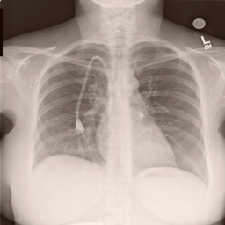

In [8]:
array_to_img(train_generator_NEW[0][0][0])

2023-01-25 22:08:10.479233: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-25 22:08:11.861751: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(32, 7, 7, 512)


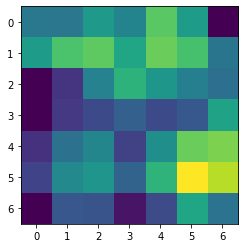

In [10]:
bottleneck_feature_example = vgg.predict(train_generator_NEW[0][0])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [11]:
model_TF = Sequential() 

model_TF.add(vgg_model) 
model_TF.add(Dense(4096, activation='relu')) 
#model.add(Dropout(0.25)) 
model_TF.add(Dense(2048, activation='relu')) 
#model.add(Dropout(0.25))
model_TF.add(Dense(1024, activation='relu')) 
#model.add(Dropout(0.25))
model_TF.add(Dense(num_classes, activation='sigmoid'))



model_TF.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [12]:
history_TF = model_TF.fit_generator(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


496/496 [==============================] - 152s 305ms/step - loss: 0.3117 - accuracy: 0.8603 - f1_m: 0.8281 - precision_m: 0.8992 - recall_m: 0.7746 - val_loss: 0.1474 - val_accuracy: 0.9419 - val_f1_m: 0.9314 - val_precision_m: 0.9705 - val_recall_m: 0.8964
Epoch 2/15
496/496 [==============================] - 78s 157ms/step - loss: 0.1903 - accuracy: 0.9231 - f1_m: 0.9141 - precision_m: 0.9462 - recall_m: 0.8853 - val_loss: 0.1172 - val_accuracy: 0.9567 - val_f1_m: 0.9532 - val_precision_m: 0.9676 - val_recall_m: 0.9396
Epoch 3/15
496/496 [==============================] - 77s 154ms/step - loss: 0.1835 - accuracy: 0.9274 - f1_m: 0.9184 - precision_m: 0.9477 - recall_m: 0.8920 - val_loss: 0.2196 - val_accuracy: 0.9052 - val_f1_m: 0.9008 - val_precision_m: 0.9216 - val_recall_m: 0.8816
Epoch 4/15
496/496 [==============================] - 79s 160ms/step - loss: 0.1610 - accuracy: 0.9364 - f1_m: 0.9330 - precision_m: 0.9472 - recall_m: 0.9198 - val_loss: 0.2321 - val_accuracy: 0.9070 - 

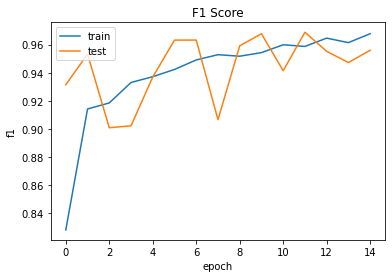

In [13]:
plt.plot(history_TF.history['f1_m'])
plt.plot(history_TF.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
test_loss= model_TF.evaluate(test_generator_NEW, verbose=1)

142/142 [==============================] - 16s 110ms/step - loss: 0.1300 - accuracy: 0.9543 - f1_m: 0.9540 - precision_m: 0.9631 - recall_m: 0.9454


In [24]:
test_loss

[0.13001087307929993,
 0.9543147087097168,
 0.9540427923202515,
 0.9630563259124756,
 0.9454225301742554]

In [25]:
dense = vgg16.VGG16(include_top=False,
                                     input_shape=input_shape) 
output = dense.layers[-1].output 
output = keras.layers.Flatten()(output) 
dense_model = Model(dense.input, output) 
dense_model.trainable = True


In [26]:
model = Sequential() 

model.add(dense_model) 
model.add(Dense(4096, activation='relu')) 
#model.add(Dropout(0.25)) 
model.add(Dense(2048, activation='relu')) 
#model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu')) 
#model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='sigmoid'))



model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 25088)             14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 2050      
Total params: 127,970,114
Trainable params: 127,970,114
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit_generator(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


496/496 [==============================] - 153s 304ms/step - loss: 0.1897 - accuracy: 0.9238 - f1_m: 0.9230 - precision_m: 0.9054 - recall_m: 0.9424 - val_loss: 0.0831 - val_accuracy: 0.9723 - val_f1_m: 0.9697 - val_precision_m: 0.9582 - val_recall_m: 0.9819
Epoch 2/15
496/496 [==============================] - 131s 264ms/step - loss: 0.0774 - accuracy: 0.9721 - f1_m: 0.9706 - precision_m: 0.9618 - recall_m: 0.9799 - val_loss: 0.0618 - val_accuracy: 0.9784 - val_f1_m: 0.9774 - val_precision_m: 0.9721 - val_recall_m: 0.9828
Epoch 3/15
496/496 [==============================] - 131s 265ms/step - loss: 0.0453 - accuracy: 0.9829 - f1_m: 0.9815 - precision_m: 0.9741 - recall_m: 0.9892 - val_loss: 0.0544 - val_accuracy: 0.9815 - val_f1_m: 0.9799 - val_precision_m: 0.9736 - val_recall_m: 0.9865
Epoch 4/15
496/496 [==============================] - 132s 266ms/step - loss: 0.0359 - accuracy: 0.9862 - f1_m: 0.9852 - precision_m: 0.9792 - recall_m: 0.9914 - val_loss: 0.0443 - val_accuracy: 0.9853

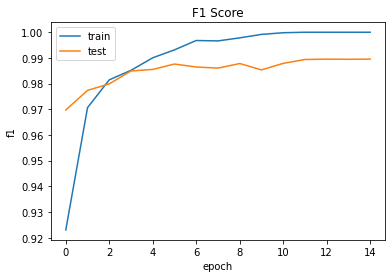

In [29]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
test_loss= model.evaluate(test_generator_NEW, verbose=1)

142/142 [==============================] - 16s 111ms/step - loss: 0.0613 - accuracy: 0.9879 - f1_m: 0.9881 - precision_m: 0.9866 - recall_m: 0.9897


In [31]:
test_loss

[0.0613483265042305,
 0.9878613948822021,
 0.9881147146224976,
 0.9865572452545166,
 0.989726185798645]